# Resturant Review Sentiment - Light Gradient Boosting
### Matthew Newton
* As we have tabular data an ensemble tree method with gradient boosting should work well.
* The same features from the linear model are used.
* LightGBM will be used as the model as it is works well with large datasets.

In [1]:
import pandas as pd
import pickle
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import lightgbm as lgb

In [6]:
df_review = pd.read_pickle("./cleaned_data/reviews_cleaned_nltk.pickle")

In [7]:
# Split training data into train data, cross validation and test data
df_review = df_review.dropna()
features = ['text', 'title', 'type', 'priceInterval', 'date', 'review_length', 'rest_rating']
X_train, X_cv, y_train, y_cv = train_test_split(df_review[features], df_review['rating'], test_size = 0.30, random_state = 0)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv[features], y_cv, test_size = 0.50, random_state = 0)

In [8]:
# Pipeline for text data (review and review title)
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000))
])

# Pipeline for categorical data (restaurant type and price)
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for numerical data (date, review length and restaurant rating)
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine all preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('review', text_pipeline, 'text'),
        ('title', text_pipeline, 'title'),
        ('type', categorical_pipeline, ['type']),
        ('price', categorical_pipeline, ['priceInterval']),
        ('num', numerical_pipeline, ['date']),
        ('review_length', numerical_pipeline, ['review_length']),
        ('rest_rating', numerical_pipeline, ['rest_rating'])
    ]
)

In [12]:
# Final pipeline combining preprocessing and LightGBM model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', lgb.LGBMClassifier(objective='multiclass', num_class=5, random_state=0, num_leaves=500, n_estimators=200, max_depth=-1, learning_rate=0.1))
]) # class_weight='balanced', other hyperparameters to tune

# Train the model
model_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 59.076417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923811
[LightGBM] [Info] Number of data points in the train set: 1430828, number of used features: 18742
[LightGBM] [Info] Start training from score -2.640850
[LightGBM] [Info] Start training from score -2.769315
[LightGBM] [Info] Start training from score -2.192273
[LightGBM] [Info] Start training from score -1.317572
[LightGBM] [Info] Start training from score -0.720422


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=10000))]),
                                                  'text'),
                                                 ('title',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=10000))]),
                                                  'title'),
                                                 ('type',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type']),
                                                 ('price',
                                                  Pipeline(steps=[('onehot',
                                                                   O...
                                                  ['priceInterval']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['date']),
                                                 ('review_length',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['review_length']),
                                                 ('rest_rating',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rest_rating'])])),
                ('lgbm',
                 LGBMClassifier(n_estimators=200, num_class=5, num_leaves=500,
                                objective='multiclass', random_state=0))])

In [13]:
# Predict on validation set
y_cv_pred = model_pipeline.predict(X_cv)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_cv, y_cv_pred))
print("\nClassification Report:\n", classification_report(y_cv, y_cv_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_cv, y_cv_pred))

Accuracy: 0.714294566968683

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.72      0.72     21763
           2       0.48      0.39      0.43     19260
           3       0.60      0.55      0.57     34492
           4       0.62      0.57      0.59     81838
           5       0.80      0.87      0.84    149253

    accuracy                           0.71    306606
   macro avg       0.64      0.62      0.63    306606
weighted avg       0.70      0.71      0.71    306606


Confusion Matrix:
 [[ 15745   4049   1403    330    236]
 [  4700   7454   5918    890    298]
 [  1091   3682  18940   9342   1437]
 [   135    300   4669  46993  29741]
 [   133     85    539  18621 129875]]


In [14]:
# Predict on validation set
y_test_pred = model_pipeline.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Accuracy: 0.714457642707579

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.73      0.73     21548
           2       0.49      0.38      0.43     19290
           3       0.60      0.55      0.57     34129
           4       0.62      0.57      0.59     82029
           5       0.80      0.87      0.84    149610

    accuracy                           0.71    306606
   macro avg       0.64      0.62      0.63    306606
weighted avg       0.70      0.71      0.71    306606


Confusion Matrix:
 [[ 15817   3871   1295    337    228]
 [  4770   7403   5893    901    323]
 [  1127   3608  18817   9129   1448]
 [   176    279   4828  46828  29918]
 [   120     91    512  18695 130192]]


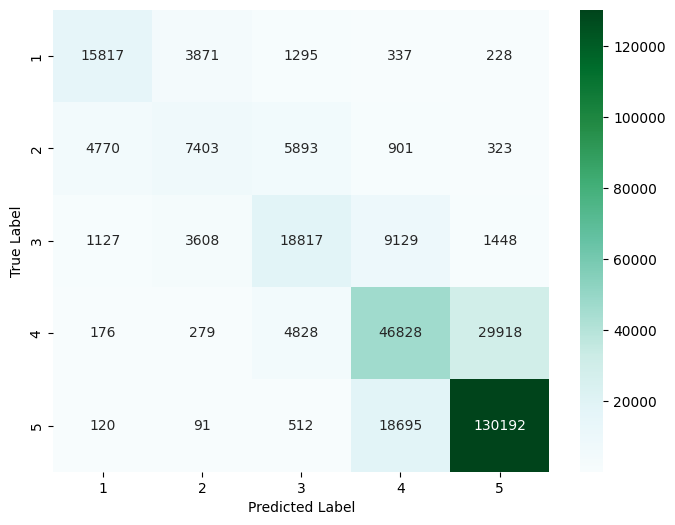

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='BuGn')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(np.arange(5) + 0.5, labels=[1, 2, 3, 4, 5])
plt.yticks(np.arange(5) + 0.5, labels=[1, 2, 3, 4, 5])
plt.savefig('./figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()